In [1]:
import os
import shutil
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd


from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.metrics import Precision, Recall, Accuracy, F1Score
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import tensorflow as tf 
import math

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Disable GPU usage for TensorFlow


2024-02-26 10:29:00.829081: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-26 10:29:00.865386: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 10:29:00.865421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 10:29:00.866319: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-26 10:29:00.872814: I tensorflow/core/platform/cpu_feature_guar

In [2]:
random.seed(422)
tf.random.set_seed(422)

In [3]:
def format_filename(suffix_number, padding=5, prefix="img_", extension="jpeg"):
    formatted_number = str(suffix_number).zfill(padding)
    filename = f"{prefix}{formatted_number}.{extension}"
    return filename

def create_dir(directory_path, remove_if_exists=True):
    # Supprimer le répertoire existant s'il existe
    if os.path.exists(directory_path) and remove_if_exists:
        shutil.rmtree(directory_path)

    # Créer le nouveau répertoire
    os.makedirs(directory_path, exist_ok=(not remove_if_exists))

In [4]:
# Chemin vers le répertoire racine
root_path = "./data/"
raw_path = os.path.join(root_path, 'raw')
proc_path = os.path.join(root_path, 'proc')

# Créer les répertoires train et test
train_path = os.path.join(proc_path, "train")
val_path = os.path.join(proc_path, "val")
test_path = os.path.join(proc_path, "test")

create_dir(train_path)
create_dir(val_path)
create_dir(test_path)

# Liste des classes (yes, no)
classes = ["yes", "no"]

file_mapping = []

counter = 0

# Pour chaque classe
for class_name in classes:
    class_path = os.path.join(raw_path, class_name)
    images = os.listdir(class_path)
    
    # Mélanger aléatoirement les images
    random.shuffle(images)
    
    # Calculer la séparation des données (60/20/20)
    val_split_index = int(0.6 * len(images))
    test_split_index = int(0.8 * len(images))
    
    # Diviser les données en ensembles d'entraînement et de test
    train_images = images[:val_split_index]
    val_images = images[val_split_index: test_split_index]
    test_images = images[test_split_index:]
    
    # Créer les répertoires de classe dans les ensembles d'entraînement et de test
    train_class_path = os.path.join(train_path, class_name)
    val_class_path = os.path.join(val_path, class_name)
    test_class_path = os.path.join(test_path, class_name)
    
    create_dir(train_class_path)
    create_dir(val_class_path)
    create_dir(test_class_path)


    for dataset_name, dataset_images, dataset_class_path in [('train', train_images, train_class_path), 
                                                             ('val', val_images, val_class_path),
                                                             ('test', test_images, test_class_path)]:
        for image in dataset_images:
            src = os.path.join(class_path, image)
            dst = os.path.join(dataset_class_path, format_filename(counter))
            shutil.copy(src, dst)
            file_mapping += [{'raw_img_path': src, 'proc_img_path': dst, 'class_name': class_name, 'dataset_name': dataset_name}]
            counter += 1

df = pd.DataFrame.from_records(file_mapping)
df.to_csv(os.path.join(root_path, 'file_mapping.csv'), index=False, header=True)
df.groupby(['dataset_name', 'class_name']).count()

raw_img_path  proc_img_path
dataset_name class_name                             
test         no                    12             12
             yes                   31             31
train        no                    34             34
             yes                   93             93
val          no                    11             11
             yes                   31             31

In [5]:
def load_images(path_to_folder):
    # Liste des classes (dossiers "yes" et "no")
    classes = ["yes", "no"]
    classes_enc = {'yes': 1, 'no': 0}

    # Compter le nombre total d'images pour allouer les tableaux numpy
    total_images = sum(len(os.listdir(os.path.join(path_to_folder, class_name))) for class_name in classes)

    X = [None] * total_images  # Préallouer pour les images
    y = [None] * total_images  # Préallouer pour les labels


    last_index = 0
    
    # Parcourir chaque classe
    for class_name in classes:
        class_path = os.path.join(path_to_folder, class_name)

        # Parcourir chaque image dans la classe
        for idx, image_name in enumerate(os.listdir(class_path)):
            image_path = os.path.join(class_path, image_name)

            # Lire l'image avec OpenCV
            image = cv2.imread(image_path)

            # Ajouter l'image et le label aux tableaux X et y
            X[last_index + idx] = image
            y[last_index + idx] = classes_enc[class_name]

        last_index = last_index + idx + 1

    return np.array(X, dtype='object'), np.array(y)

In [6]:
X_train, y_train = load_images(train_path)
X_val, y_val = load_images(val_path)
X_test, y_test = load_images(test_path)

In [7]:
def display_images(X, y, n):
    # Filtrer les images par classe
    yes_images =  X[y == 1][:n]
    no_images = X[y == 0][:n]

    # Calculer le nombre de lignes et colonnes pour chaque classe
    n_rows = int(math.sqrt(n))
    n_cols = math.ceil(n / n_rows)

    # Créer la figure pour la classe "yes"
    fig_yes, axs_yes = plt.subplots(n_rows, n_cols, figsize=(12, 10))
    fig_yes.suptitle('Class: Yes')

    # Afficher des images de la classe "yes"
    for i in range(min(n, len(yes_images))):
        axs_yes[i // n_cols, i % n_cols].imshow(yes_images[i])

    # Créer la figure pour la classe "no"
    fig_no, axs_no = plt.subplots(n_rows, n_cols, figsize=(12, 10))
    fig_no.suptitle('Class: No')

    # Afficher des images de la classe "no"
    for i in range(min(n, len(no_images))):
        axs_no[i // n_cols, i % n_cols].imshow(no_images[i])

    plt.show()

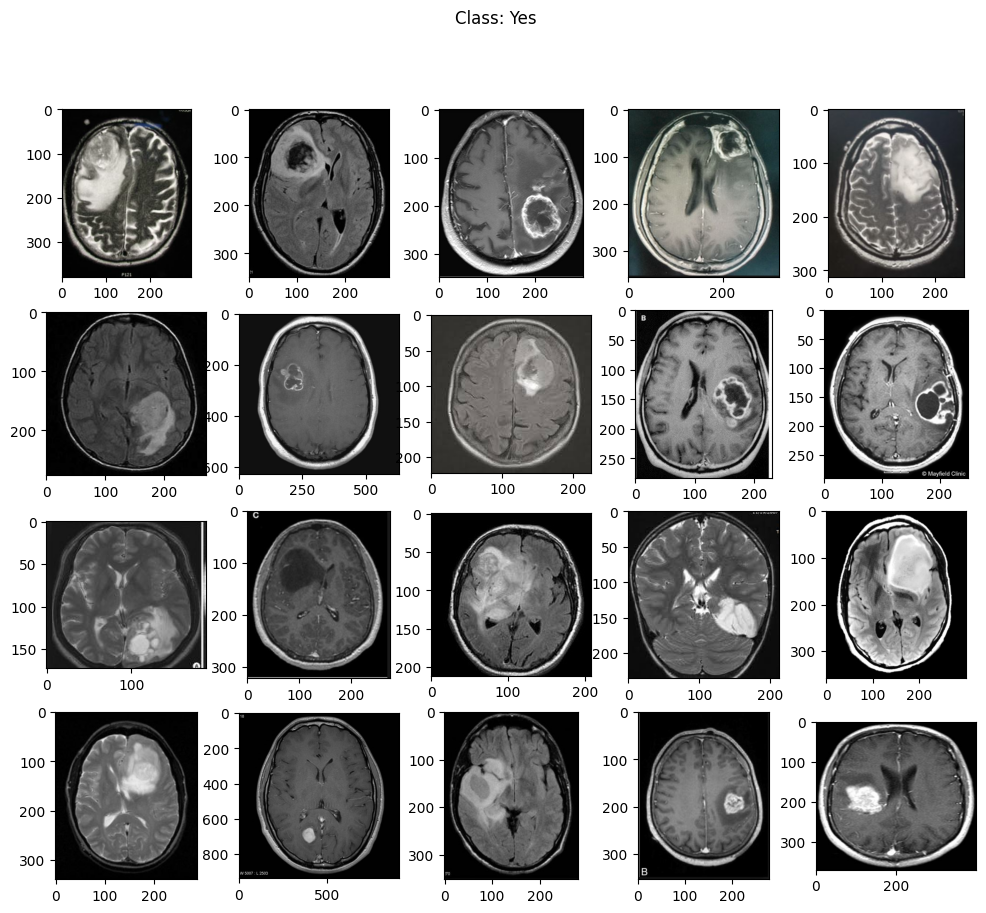

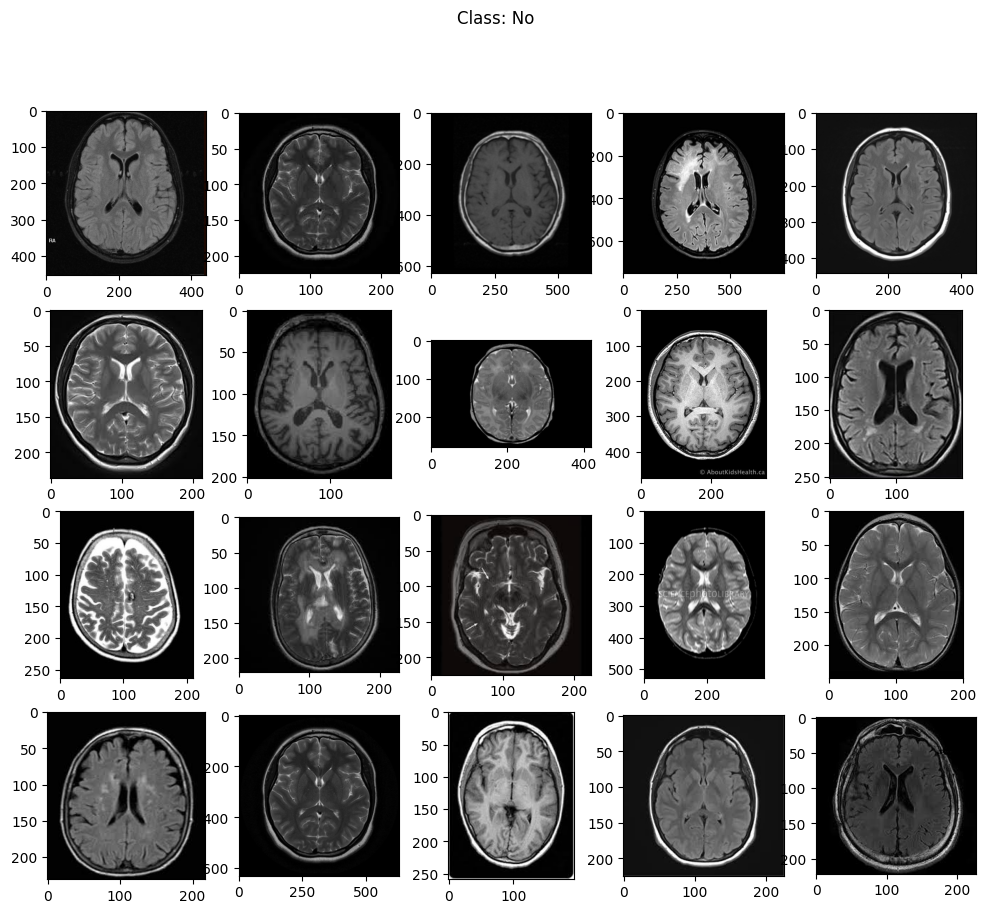

In [8]:
import math

# Utilisation de la fonction avec X et y provenant du train
display_images(X_train, y_train, n=20)

In [9]:
def normalize_images(X, target_size):
    normalized_images = [None] * len(X)

    for i, img in enumerate(X):
        if len(img.shape) == 3:
            # Convertir en niveaux de gris si c'est pas déjà le cas
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Appliquer un filtre pour supprimer le bruit (par exemple, un filtre gaussien)
        denoised_img = cv2.GaussianBlur(gray_img, (5, 5), 0)

        # Détecter les contours pour trouver le crop optimal
        _, thresh = cv2.threshold(denoised_img, 30, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Trouver le contour avec la plus grande aire
            max_contour = max(contours, key=cv2.contourArea)

            # Obtenir les coordonnées du rectangle englobant
            x, y, w, h = cv2.boundingRect(max_contour)

            # Cropper l'image pour obtenir la région d'intérêt
            cropped_img = img[y:y+h, x:x+w]

            # Redimensionner à target_size (pour s'assurer que toutes les images ont la même taille)
            normalized_images[i] = cv2.resize(cropped_img, target_size, interpolation=cv2.INTER_AREA)
        else:
            # Redimensionner à target_size si aucun contour n'est détecté
            normalized_images[i] = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

    return np.array(normalized_images)

In [10]:
# Utilisation de la fonction avec X (images non normalisées) et la taille cible
target_size = (224, 224)
X_train_norm = normalize_images(X_train, target_size)
X_val_norm = normalize_images(X_val, target_size)
X_test_norm = normalize_images(X_test, target_size)

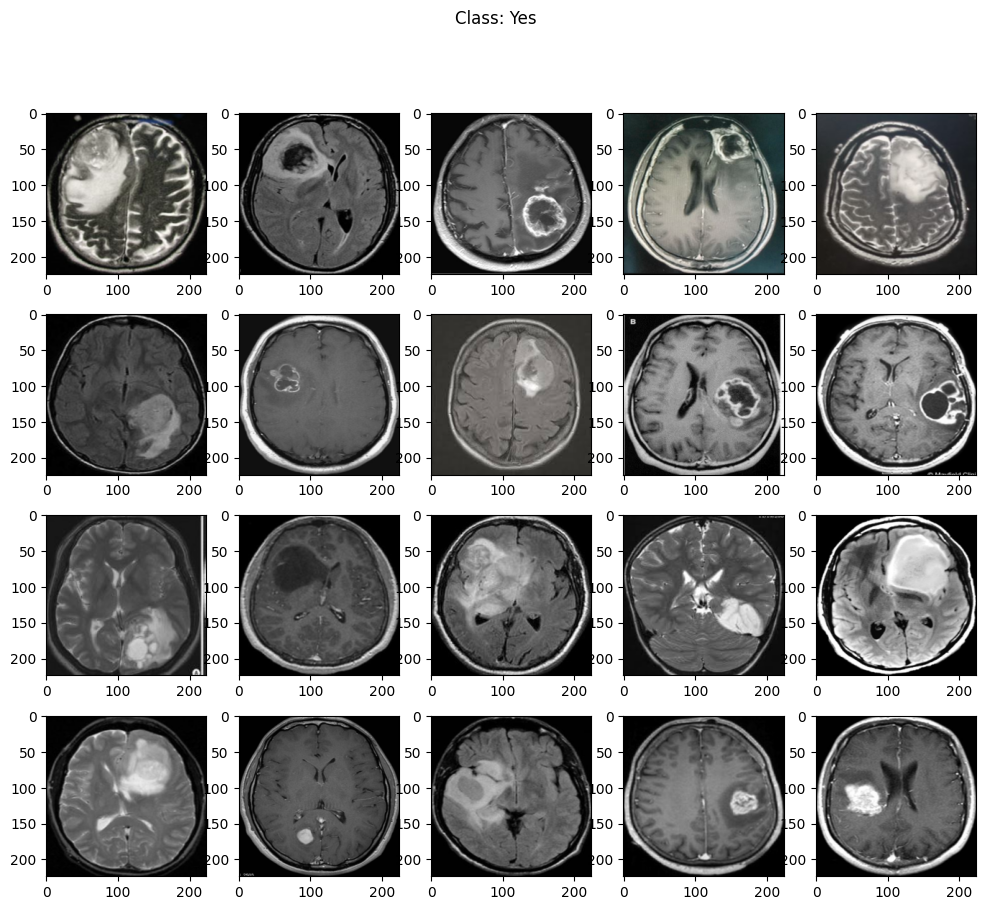

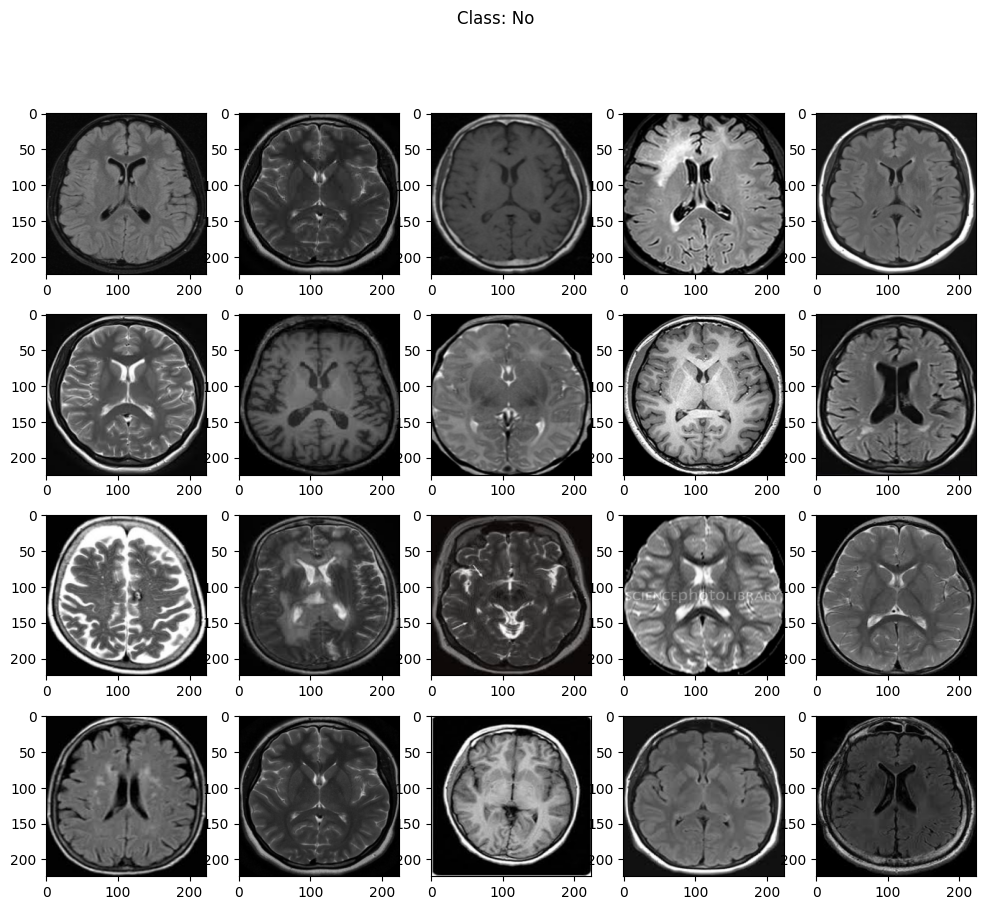

In [11]:
display_images(X_train_norm, y_train, 20)

In [12]:
# Créer un modèle VGG-16 pré-entraîné (ne pas inclure la couche dense finale)
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))

NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='sigmoid'))

# figer les poids du VGG
model.layers[0].trainable = False

# Compiler le modèle
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

# Afficher la structure du modèle
model.summary()

# Créer un générateur d'images pour la data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.01,
    height_shift_range=0.01,
    zoom_range=0.05,
    shear_range=0.01,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    vertical_flip=True
)

# Ajuster le générateur aux données d'entraînement
datagen.fit(X_train_norm)

# Créer un callback d'arrêt anticipé
early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveiller la perte sur l'ensemble de validation
    patience=10,  # Arrêter l'entraînement si la perte ne diminue pas pendant 3 époques consécutives
    restore_best_weights=True,  # Restaurer les poids du modèle aux meilleurs atteints pendant l'entraînement
    verbose=1  # Afficher des messages lors de l'arrêt anticipé
)

BATCH_SIZE = 16

# Entraîner le modèle avec l'augmentation de données
history = model.fit(datagen.flow(X_train_norm, y_train, batch_size=BATCH_SIZE),
                    epochs=50,
                    steps_per_epoch=len(X_train_norm) // BATCH_SIZE,
                    validation_data=(X_val_norm, y_val),
                    callbacks=[early_stopping])

model.evaluate(X_test_norm, y_test)

2024-02-26 10:29:16.119149: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 32)                802848    
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

[0.2498868852853775, 0.8837209343910217]

In [13]:
X_train_norm.shape

(127, 224, 224, 3)

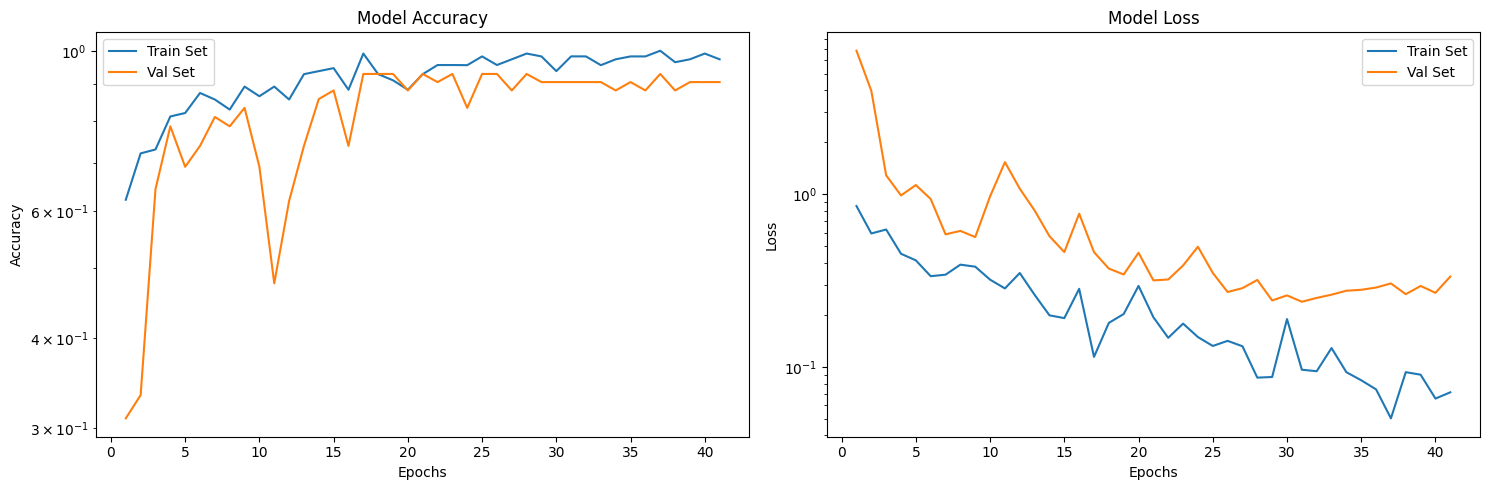

In [14]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.yscale('log')
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.yscale('log')
plt.plot(epochs_range, loss, label='Train Set', )
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [15]:
y_pred_prob = model.predict(X_test_norm)

2/2 [==============================] - 8s 2s/step


In [16]:
y_pred = (y_pred_prob > 0.5).flatten()

In [17]:
y_pred

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True, False, False, False, False,
       False, False,  True, False, False, False, False])

In [18]:
y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

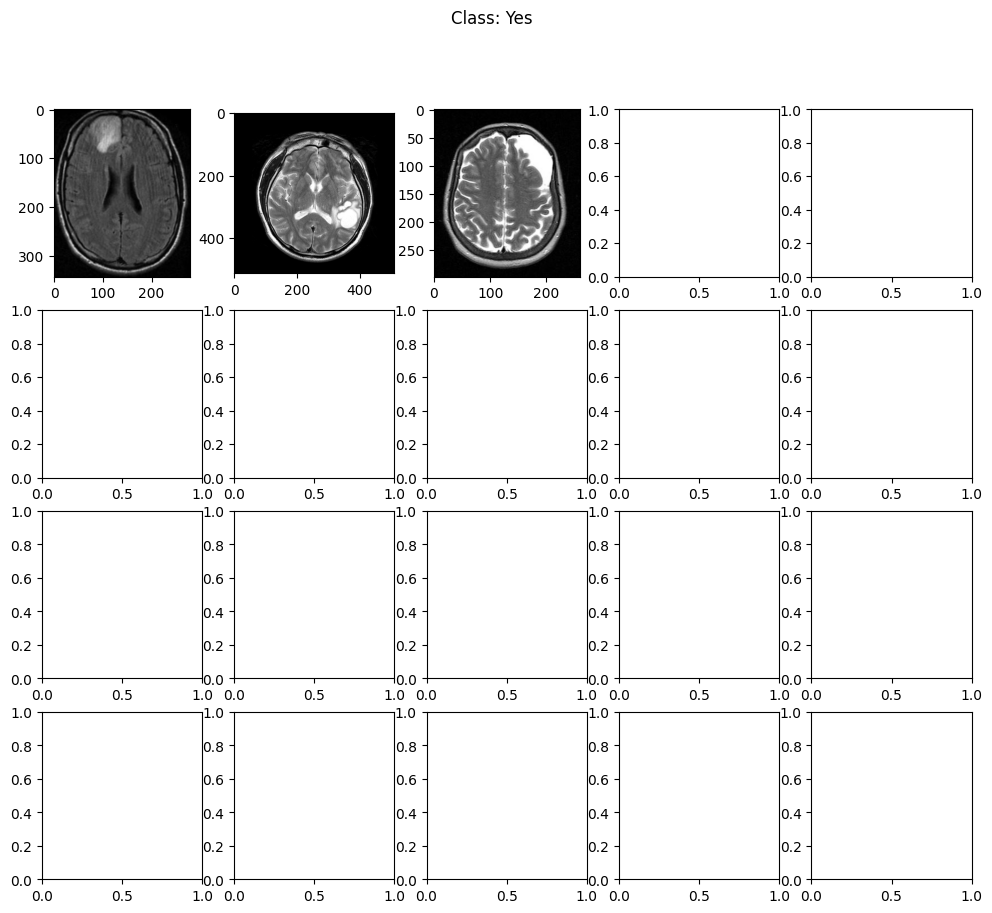

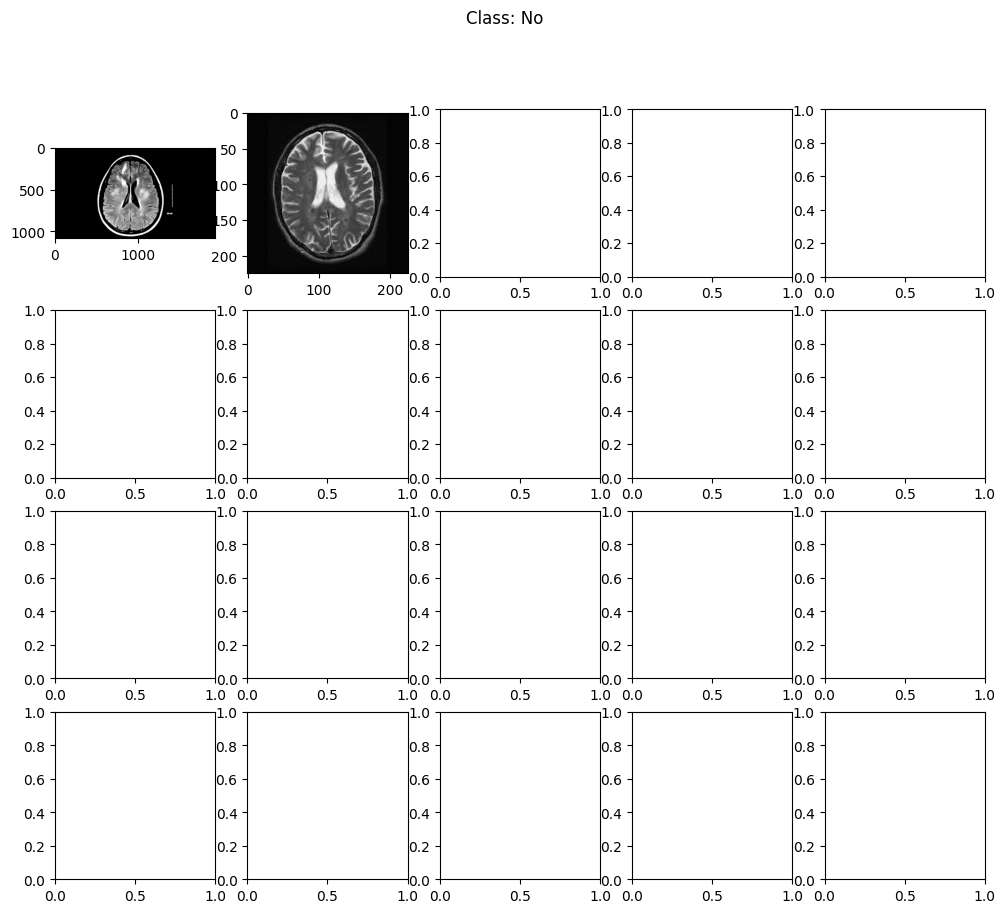

In [19]:
not_ok_y_test = y_test[y_pred != y_test]
not_ok_X_test = X_test[y_pred != y_test]

display_images(not_ok_X_test, not_ok_y_test, 20)

recall =  0.9032258064516129
precision =  0.9333333333333333
f1 score =  0.9180327868852459
rocauc =  0.9596774193548387


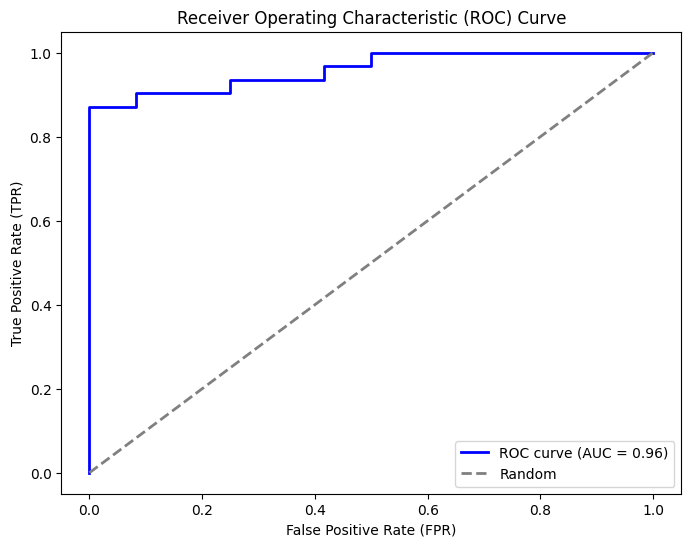

In [20]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, roc_curve

print('recall = ', recall_score(y_test, y_pred))
print('precision = ', precision_score(y_test, y_pred))
print('f1 score = ', f1_score(y_test, y_pred))
print('rocauc = ', roc_auc_score(y_test, y_pred_prob))

# Calculate ROC curve metrics
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

(array([ 7.,  2.,  3.,  1.,  0.,  1.,  2.,  1.,  1., 25.]),
 array([8.70884719e-07, 9.97806489e-02, 1.99560434e-01, 2.99340218e-01,
        3.99120003e-01, 4.98899788e-01, 5.98679543e-01, 6.98459327e-01,
        7.98239112e-01, 8.98018897e-01, 9.97798681e-01]),
 <BarContainer object of 10 artists>)

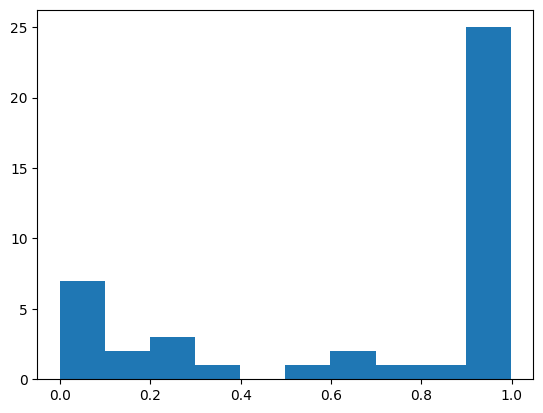

In [21]:
plt.hist(y_pred_prob)

In [22]:
model.save('model_tumeur.keras')

In [1]:
import mlflow
import sys
sys.path.append('../')
from config import MLFLOW_SERVER

mlflow.set_tracking_uri(uri=MLFLOW_SERVER)

params = {
    'batch_size' : 16,
    'epoch' : 50
}

# Create a new MLflow Experiment
mlflow.set_experiment("MLflow Neuroguard")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    mlflow.log_metric("recall", recall_score(y_test, y_pred))
    mlflow.log_metric("precision", precision_score(y_test, y_pred))
    mlflow.log_metric("f1 score", f1_score(y_test, y_pred) )
    mlflow.log_metric("rocauc", roc_auc_score(y_test, y_pred_prob) )

    # # Log the model
    mlflow.tensorflow.log_model(model, artifact_path='Neuroguard')

2024/02/27 09:33:15 INFO mlflow.tracking.fluent: Experiment with name 'MLflow Neuroguard' does not exist. Creating a new experiment.


NameError: name 'recall_score' is not defined